# DATA 602 Final Project
### Naomi Buell, Richie Rivera, Alexander Simon

## Abstract

[Insert abstract here. no more than 300 words.]

## Introduction

Our research question is: Is there a correlation between pain reliever misuse in US states and whether [states have expanded Medicaid](https://www.kff.org/affordable-care-act/issue-brief/status-of-state-medicaid-expansion-decisions-interactive-map/)? How has Medicaid expansion affected opioid misuse in the US? We plan to investigate the correlation between pain reliever misuse and states that have expanded Medicaid, and whether the rate of opioid misuse decreased after states expanded their Medicaid programs. We picked this topic because, as professionals in public health and biology, we are well aware of the toll that substance use disorders have taken, and the potential that Medicaid expansion under the Affordable Care Act (ACA) has to improve access to treatment for these disorders. 

We will obtain data on the prevalence of pain reliever misuse in each state from the [National Survey on Drug Use and Health (NSDUH)](https://datatools.samhsa.gov/nsduh/2019/nsduh-2018-2019-rd02yr/crosstab?row=PNRNMYR&column=STUSAB&weight=DASWT_1) from the Substance and Mental Health Services Administration (SAMHSA) and the status of each state’s decision on Medicaid expansion from [KFF](https://www.kff.org/affordable-care-act/issue-brief/status-of-state-medicaid-expansion-decisions-interactive-map/), a health policy organization. We will use the pandas and matplotlib libraries for our data analysis. Below is our exploratory data analysis and some summary statistics.

## Data Wrangling 

[Insert tidying of your data, manipulating missing values, structuring of
your data, etc.]

Our data are from the SAMHSA [National Survey on Drug Use and Health (NSDUH)](https://datatools.samhsa.gov/) 2-year restricted-use data sets for 2015-2016, 2016-17, 2017-18, 2018-19, and 2021-2022. No data related to our research question were available prior to 2015 (survey question of interest was not being asked yet) or for 2020 (likely due to COVID).

On the SAMHSA Data Tools webpage, we created "crosstabs" (data subsets) for the following variables and downloaded the CSV files:
-  PNRNMYR - During the past 12 months, if they misused prescription pain relievers
-  STUSAB - State US abbreviation

We also downloaded Medicaid expansion data (CSV) from [KFF](https://www.kff.org/affordable-care-act/issue-brief/status-of-state-medicaid-expansion-decisions-interactive-map/).

## Exploratory Data Analysis

[Insert EDA - well-labeled graphs/plots that are appropriate to your analysis. Each
visualization includes a description of what is being shown.]


### NSDUH Opioid Misuse Data

Below we import the NSDUH datasets, create dataframes, and explore this data.  

In [1]:
# Import libraries
import pandas as pd
import os

# Set up filepaths
file_paths = [
    'data/STUSAB X PNRNMYR (2015-16).csv',
    'data/STUSAB X PNRNMYR (2016-17).csv',
    'data/STUSAB X PNRNMYR (2017-18).csv',
    'data/STUSAB X PNRNMYR (2018-19).csv',
    'data/STUSAB X PNRNMYR (2021-22).csv',
]

# Iterate over each path to add the CSV file to a list
df_collection = []
for path in file_paths:
    print(f'Reading in "{path}"')

    t_df = pd.read_csv(path)

    t_df['rpt_yr'] = pd.to_datetime(f'20{path[28:30]}-01-01')

    df_collection.append(
        t_df
    )

# Combine the collection of dataframes into one
df = pd.concat(df_collection)

print(df.head())

Reading in "data/STUSAB X PNRNMYR (2015-16).csv"
Reading in "data/STUSAB X PNRNMYR (2016-17).csv"
Reading in "data/STUSAB X PNRNMYR (2017-18).csv"
Reading in "data/STUSAB X PNRNMYR (2018-19).csv"
Reading in "data/STUSAB X PNRNMYR (2021-22).csv"
  STATE US ABBREVIATION RC-PAIN RELIEVERS - PAST YEAR MISUSE  Total %  \
0               Overall                              Overall    1.000   
1                    AK                              Overall    0.002   
2                    AL                              Overall    0.015   
3                    AR                              Overall    0.009   
4                    AZ                              Overall    0.021   

   Total % SE  Total % CI (lower)  Total % CI (upper)  Row %  Row % SE  \
0      0.0000                 NaN                 NaN    1.0       0.0   
1      0.0001               0.002               0.002    1.0       0.0   
2      0.0006               0.014               0.016    1.0       0.0   
3      0.0004       

Below, we print list of columns, length, number of non-missing observations, and data types.

In [2]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 780 entries, 0 to 155
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   STATE US ABBREVIATION                 780 non-null    object        
 1   RC-PAIN RELIEVERS - PAST YEAR MISUSE  780 non-null    object        
 2   Total %                               780 non-null    float64       
 3   Total % SE                            780 non-null    float64       
 4   Total % CI (lower)                    775 non-null    float64       
 5   Total % CI (upper)                    775 non-null    float64       
 6   Row %                                 780 non-null    float64       
 7   Row % SE                              780 non-null    float64       
 8   Row % CI (lower)                      520 non-null    float64       
 9   Row % CI (upper)                      520 non-null    float64       
 10  Column 

All 780 observations of the column `Count` are missing, but we can instead use the `Weighted Count` column for our analysis, so this is OK.<sup>[1](#footnote1)</sup> There are up to 260 missing observations in the columns of this dataset, however, our main variables of interest `STATE US ABBREVIATION`, `RC-PAIN RELIEVERS - PAST YEAR MISUSE`, and `Row %` are complete. We may also use `Row % CI (lower)` and `Row % CI (upper)`, which are 67% complete in the full dataset, but (as explored later) are 100% complete after we filter data down to observations of interest.

<sup id="footnote1">1</sup> Note that `Row %`s are rounded, so we may opt to calculate prevalence rates ourselves using `Weighted Count` for more precision.

Below are the means, medians, and other summary statistics of numeric columns.

In [3]:
# Summary statistics
df.describe()

,Total %,Total % SE,Total % CI (lower),Total % CI (upper),Row %,Row % SE,Row % CI (lower),Row % CI (upper),Column %,Column % SE,Column % CI (lower),Column % CI (upper),Weighted Count,Count,Count SE,rpt_yr
count,780.000000,780.000000,775.000000,775.000000,780.000000,780.000000,520.000000,520.000000,780.000000,780.000000,765.000000,765.000000,7.800000e+02,0.0,7.800000e+02,780
mean,0.025624,0.000510,0.018386,0.020391,0.666667,0.003592,0.489262,0.510738,0.038456,0.001267,0.017306,0.022429,7.013690e+06,NaN,1.666756e+05,2018-05-27 00:00:00
min,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.007000,0.022000,0.001000,0.000000,0.001000,0.002000,1.200000e+04,NaN,2.000000e+03,2016-01-01 00:00:00
25%,0.001000,0.000100,0.001000,0.001000,0.045000,0.000000,0.030000,0.050000,0.005000,0.000400,0.004000,0.006000,2.555000e+05,NaN,2.800000e+04,2017-01-01 00:00:00
50%,0.006000,0.000300,0.005000,0.006000,0.961000,0.004300,0.484000,0.516000,0.014000,0.000800,0.012000,0.016000,1.526000e+06,NaN,7.850000e+04,2018-01-01 00:00:00
75%,0.018000,0.000800,0.017000,0.020000,1.000000,0.005800,0.950000,0.970000,0.024250,0.001700,0.020000,0.028000,5.025000e+06,NaN,2.152500e+05,2019-01-01 00:00:00
max,1.000000,0.004300,0.968000,0.971000,1.000000,0.011800,0.978000,0.993000,1.000000,0.012300,0.118000,0.146000,2.809260e+08,NaN,3.041000e+06,2022-01-01 00:00:00
std,0.110711,0.000592,0.078245,0.078851,0.444593,0.002882,0.460170,0.460170,0.136495,0.001456,0.020440,0.024208,3.029175e+07,NaN,2.692497e+05,NaN


Here is a preview of our data after filtering down to just our columns and rows of interest.

In [4]:
# Selecting columns of interest from data
df_cols = df[['STATE US ABBREVIATION',
'RC-PAIN RELIEVERS - PAST YEAR MISUSE',
'Row %',
'Row % CI (lower)',
'Row % CI (upper)',
'Weighted Count',
'rpt_yr']]

# Subset the rows with states, removing the overall US observations
df_states = df_cols[df_cols['STATE US ABBREVIATION'] != "Overall"]

# Subset the rows where RC-PAIN RELIEVERS - PAST YEAR MISUSE = "1 - Misused within the past year" to get prevalence of opioid misuse
df_filtered = df_states[df_states['RC-PAIN RELIEVERS - PAST YEAR MISUSE'] == "1 - Misused within the past year"]

# Preview filtered data
df_filtered.head()


,STATE US ABBREVIATION,RC-PAIN RELIEVERS - PAST YEAR MISUSE,Row %,Row % CI (lower),Row % CI (upper),Weighted Count,rpt_yr
105,AK,1 - Misused within the past year,0.046,0.038,0.057,27000,2016-01-01
106,AL,1 - Misused within the past year,0.053,0.043,0.065,215000,2016-01-01
107,AR,1 - Misused within the past year,0.048,0.038,0.059,117000,2016-01-01
108,AZ,1 - Misused within the past year,0.047,0.037,0.060,270000,2016-01-01
109,CA,1 - Misused within the past year,0.048,0.043,0.054,1571000,2016-01-01


Here are  summary statistics of our numeric variables in this filtered data frame.

In [5]:
# Show missingness of filtered data
print(df_filtered.info())

# Show summary statistics of filtered data
df_filtered.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 255 entries, 105 to 155
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   STATE US ABBREVIATION                 255 non-null    object        
 1   RC-PAIN RELIEVERS - PAST YEAR MISUSE  255 non-null    object        
 2   Row %                                 255 non-null    float64       
 3   Row % CI (lower)                      255 non-null    float64       
 4   Row % CI (upper)                      255 non-null    float64       
 5   Weighted Count                        255 non-null    int64         
 6   rpt_yr                                255 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 15.9+ KB
None


,Row %,Row % CI (lower),Row % CI (upper),Weighted Count,rpt_yr
count,255.000000,255.000000,255.000000,2.550000e+02,255
mean,0.038808,0.029490,0.051329,2.045686e+05,2018-05-27 00:00:00
min,0.013000,0.007000,0.022000,1.200000e+04,2016-01-01 00:00:00
25%,0.033000,0.024000,0.044000,5.100000e+04,2017-01-01 00:00:00
50%,0.039000,0.030000,0.051000,1.540000e+05,2018-01-01 00:00:00
75%,0.045000,0.034000,0.058000,2.495000e+05,2019-01-01 00:00:00
max,0.065000,0.051000,0.083000,1.571000e+06,2022-01-01 00:00:00
std,0.008746,0.007924,0.010386,2.335462e+05,NaN


After filtering data, we have 100% completeness. States have, on average, 3.9% prevalence of opioid misuse in the past 12 months. 

### KFF State Medicaid Expansion Data

Below we import the KFF dataset and explore this data.  

In [6]:
# Import KFF data
path_kff = "data/raw_data_kff.xlsx"

df_kff = pd.read_excel(path_kff, skiprows=2)

df_kff.head()

,Location,Status of Medicaid Expansion Decision,Implemented Expansion On
0,Arizona,Adopted,2014-01-01 00:00:00
1,Arkansas,Adopted,2014-01-01 00:00:00
2,California,Adopted,2014-01-01 00:00:00
3,Colorado,Adopted,2014-01-01 00:00:00
4,Connecticut,Adopted,2014-01-01 00:00:00


We convert the state names to abbreviations to match NSDUH data.

In [7]:
# Create a dictionary with state names and their abbreviations as key:value pairs
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",  # Delete?
    "Guam": "GU",  # Delete?
    "Northern Mariana Islands": "MP",  # Delete?
    "Puerto Rico": "PR",
    "United States": "US",
}

# Map the state names in the KFF dataframe to the corresponding abbreviation
df_kff['Abbrev'] = df_kff['Location'].map(us_state_to_abbrev)

df_kff.head()

,Location,Status of Medicaid Expansion Decision,Implemented Expansion On,Abbrev
0,Arizona,Adopted,2014-01-01 00:00:00,AZ
1,Arkansas,Adopted,2014-01-01 00:00:00,AR
2,California,Adopted,2014-01-01 00:00:00,CA
3,Colorado,Adopted,2014-01-01 00:00:00,CO
4,Connecticut,Adopted,2014-01-01 00:00:00,CT


Below, we print the list of columns, length, number of non-missing observations, and data types.

In [8]:
# Info
df_kff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Location                               57 non-null     object
 1   Status of Medicaid Expansion Decision  52 non-null     object
 2   Implemented Expansion On               52 non-null     object
 3   Abbrev                                 52 non-null     object
dtypes: object(4)
memory usage: 2.0+ KB


We convert the `Implemented Expansion On` variable to a datetime datatype and summarize it below.

In [9]:
# Convert to datetime
df_kff['Implemented Expansion On'] = pd.to_datetime(df_kff['Implemented Expansion On'], errors='coerce')

# Range of dates
df_kff.describe()

,Implemented Expansion On
count,41
mean,2015-10-09 03:30:43.902438912
min,2014-01-01 00:00:00
25%,2014-01-01 00:00:00
50%,2014-01-01 00:00:00
75%,2016-01-01 00:00:00
max,2023-12-01 00:00:00


41 states expanded Medicaid so far (missing dates indicate that a state has not yet adopted Medicaid expansion). Most states who have expanded Medicaid did so on the first day of 2014. The last state to expand Medicaid, North Carolina, did so in December 2023.

Lastly, we'll combine the KFF and NSDUH data into one dataframe that we will perform our analysis on:

In [10]:
working_df = df_filtered.merge(
    df_kff,
    left_on = 'STATE US ABBREVIATION',
    right_on = 'Abbrev',
    how = 'left'
)

working_df.head()

,STATE US ABBREVIATION,RC-PAIN RELIEVERS - PAST YEAR MISUSE,Row %,Row % CI (lower),Row % CI (upper),Weighted Count,rpt_yr,Location,Status of Medicaid Expansion Decision,Implemented Expansion On,Abbrev
0,AK,1 - Misused within the past year,0.046,0.038,0.057,27000,2016-01-01,Alaska,Adopted,2015-09-01,AK
1,AL,1 - Misused within the past year,0.053,0.043,0.065,215000,2016-01-01,Alabama,Not Adopted,NaT,AL
2,AR,1 - Misused within the past year,0.048,0.038,0.059,117000,2016-01-01,Arkansas,Adopted,2014-01-01,AR
3,AZ,1 - Misused within the past year,0.047,0.037,0.060,270000,2016-01-01,Arizona,Adopted,2014-01-01,AZ
4,CA,1 - Misused within the past year,0.048,0.043,0.054,1571000,2016-01-01,California,Adopted,2014-01-01,CA


## Data Analysis

Below, we create a binary variable for whether the state OUD observation year occured after Medicaid expansion, called `post`.

In [11]:
working_df['post'] = working_df['rpt_yr'] >= working_df['Implemented Expansion On']

working_df.head()

,STATE US ABBREVIATION,RC-PAIN RELIEVERS - PAST YEAR MISUSE,Row %,Row % CI (lower),Row % CI (upper),Weighted Count,rpt_yr,Location,Status of Medicaid Expansion Decision,Implemented Expansion On,Abbrev,post
0,AK,1 - Misused within the past year,0.046,0.038,0.057,27000,2016-01-01,Alaska,Adopted,2015-09-01,AK,True
1,AL,1 - Misused within the past year,0.053,0.043,0.065,215000,2016-01-01,Alabama,Not Adopted,NaT,AL,False
2,AR,1 - Misused within the past year,0.048,0.038,0.059,117000,2016-01-01,Arkansas,Adopted,2014-01-01,AR,True
3,AZ,1 - Misused within the past year,0.047,0.037,0.060,270000,2016-01-01,Arizona,Adopted,2014-01-01,AZ,True
4,CA,1 - Misused within the past year,0.048,0.043,0.054,1571000,2016-01-01,California,Adopted,2014-01-01,CA,True


We create two heatmaps of average states' average OUD prevalence rates pre and post.

In [12]:
# Two heatmaps


We also make a scatter plot of state prevalence pre- and post-expansion.

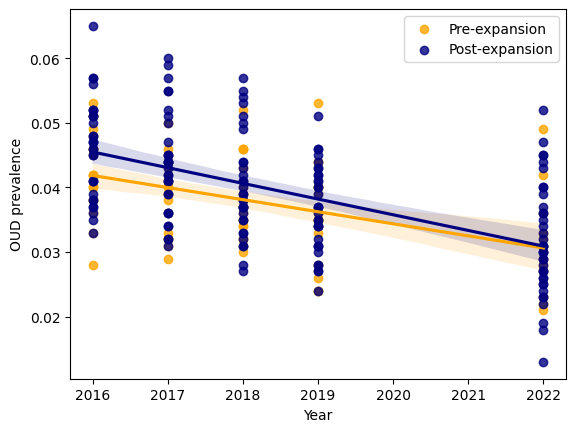

In [22]:
# Scatter plot

import matplotlib.pyplot as plt
import seaborn as sns

# Manipulate df prior to plotting
scatter_df = working_df.dropna(subset=['rpt_yr', 'Row %']) # Filter out rows with NaN values in columns of interest
scatter_df['rpt_yr'] = scatter_df['rpt_yr'].dt.year # Pulling just the year integer for graphing

# Add trend lines
sns.regplot(data=scatter_df[scatter_df['post'] == 0], x='rpt_yr', y='Row %', scatter=True, color='orange', label='Pre-expansion')
sns.regplot(data=scatter_df[scatter_df['post'] == 1], x='rpt_yr', y='Row %', scatter=True, color='navy', label='Post-expansion')
sns.catplot # does jitter

# Add labels and title
plt.xlabel('Year')
plt.ylabel('OUD prevalence')
#plt.title('Post-expansion appears to have higher opioid rates than pre- due to limited data on pre-expansion states.')
plt.legend()

# Show the plot
plt.show()

In [20]:
from sklearn.linear_model import LinearRegression

# Create Xs (pre and post) from the year column values. Reshape X
X_pre = scatter_df[scatter_df['post'] == 0]['rpt_yr'].values.reshape(-1, 1)
X_post = scatter_df[scatter_df['post'] == 1]['rpt_yr'].values.reshape(-1, 1)

# Create y (pre and post) from the OUD rate column's values
y_pre= scatter_df[scatter_df['post'] == 0]['Row %'].values
y_post = scatter_df[scatter_df['post'] == 1]['Row %'].values

# Fit the model
model_pre = LinearRegression().fit(X_pre, y_pre) 
model_post = LinearRegression().fit(X_post, y_post) 

# Print the slopes
print(f"Slope for Pre-expansion: {model_pre.coef_[0]}")
print(f"Slope for Post-expansion: {model_post.coef_[0]}")

Slope for Pre-expansion: -0.001869911210993625
Slope for Post-expansion: -0.002429504678648636


The slope post-expansion is steeper than that for pre-expansion, suggesting that Medicaid expansion helps to decrease opioid misuse faster! This is a favorable sign for Medicaid expansion.

## Conclusion

[Insert]s